## Reddit comments
### Generate PCA based "toxicity" score

In this notebook, I analyze a set of features associated with a corpus of comments sampled from the Reddit subredit r/politics.

The goal is to create a standardized score based on comment features that represents whether the comment was positively or negatively received by other users. A highly negative comment score could be deemed "toxic".

The comments were downloaded from a target Reddit using PRAW and a custom script. Each comment has the following associated features:

- comment ID#
- subreddit name
- post ID#
- parent ID#
- comment timestamp
- comment age since post time (secs)
- comment age since now (secs)
- user ID#
- user name
- user account created date
- user account comment karma
- user account link karma
- #replies to the comment
- contoversial flag state
- comment vote score
- comment text (converted to ascii)



### Setup notebook and load reddit comment data

In [4]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np
import datetime
import time
import csv

# subdir containing collected comment data as csv files
srcdir = './data_collected/'

# select a file containing collected comments
csvfilename = 'comment_sample_politics190220_002433'

df = pd.read_csv(srcdir+csvfilename+'.csv')

# remove any deleted or removed comments 
df = df[(df.text!='[deleted]') & (df.text!='[removed]')]

print(df.shape)

(83282, 16)


### Create a few features for visualization, select analysis features

For a start, I'm going to look at several features that might be correlated with user approval or disapproval of a comment.

- user account comment karma
- user account link karma
- #replies to the comment
- #days difference between post date and comment date
- comment vote score

#### Note that comment vote score is going to be the most useful feature, since it's a direct measurement of reader approval/disapproval. Therefore, I'll be comparing the other features to it: if they correlate with vote score, then they will be included in the PCA score calculation.


In [5]:
import seaborn as sns

# get sign of vote score
df['score_sign'] = (df.score<0).map({True:'negative',False:'positive'})

# convert seconds time difference between post date and comment date into days
df['u_days'] = ((df.time-df.u_created)/86400)

# specify which feature columns to analyze
cols2compare = ['u_comment_karma', 'u_link_karma', 'num_replies', 
                'u_days', 'score']


### Feature distributions

Except for u_days, all of these features have extremely peaky distributions. I'd like to try and normalize them a bit before throwing them into the PCA.

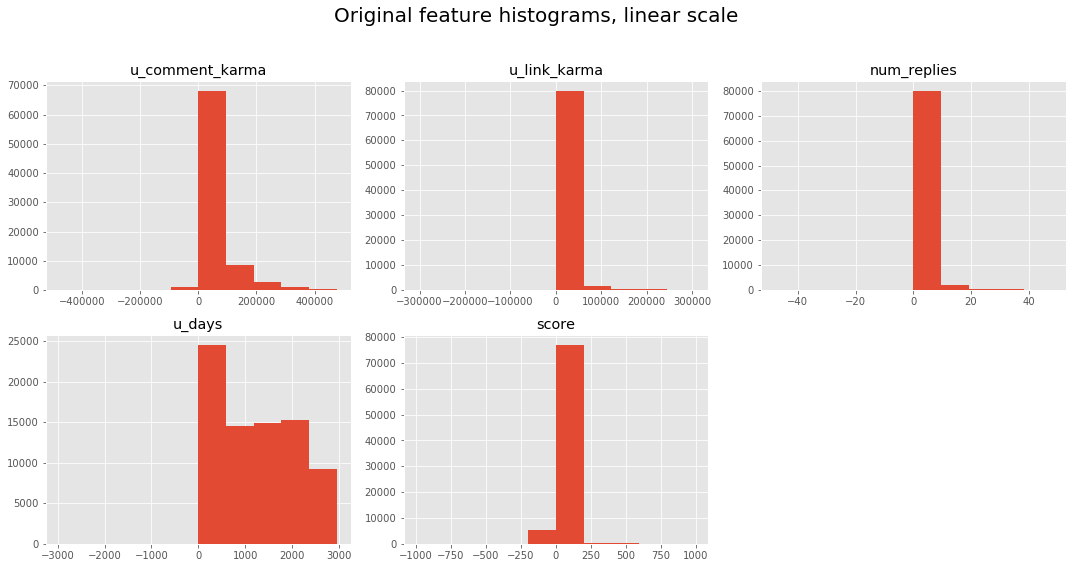

In [6]:
plt.figure(figsize=(15, 8))

for plotnum, colname in zip(range(len(cols2compare)), cols2compare):
    std3 = 3*df[colname].std()
    plt.tight_layout()
    plt.subplot(2,3,plotnum+1)
    plt.hist(df[colname], range=(-std3,std3))
    plt.title(colname)

plt.tight_layout(rect=[0, 0, 1, 0.90]);
plt.suptitle('Original feature histograms, linear scale', fontsize=20);


### Feature distributions on log y scale

Things look a little better on log y scale, so I'll log transform the features.

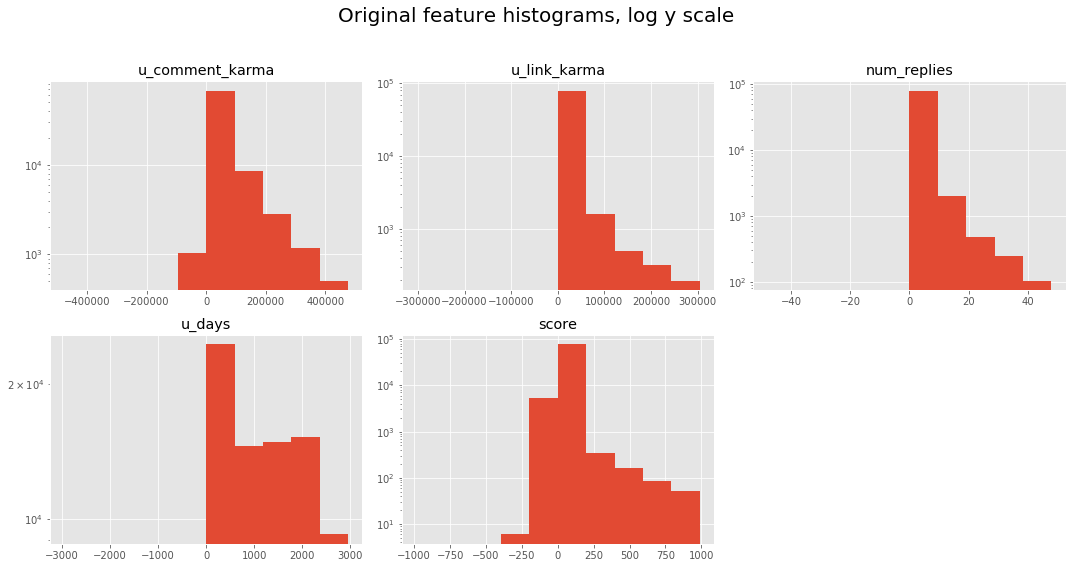

In [7]:
plt.figure(figsize=(15, 8))

for plotnum, colname in zip(range(len(cols2compare)), cols2compare):
    std3 = 3*df[colname].std()
    plt.tight_layout()
    plt.subplot(2,3,plotnum+1)
    plt.hist(df[colname], range=(-std3,std3), log=True)
    plt.title(colname)

plt.tight_layout(rect=[0, 0, 1, 0.90]);
plt.suptitle('Original feature histograms, log y scale', fontsize=20);


## Pairplot features

I'm using vote score as a primary feature, and comparing the other features against it. If a given feature is correlated with score (and thus might be useful for labelling comments toxic vs not), then it should have a non-zero regression slope. 

Note that I'm log transforming the features and I've separately plotted samples by whether their score is less than 1 (blue) or greater than 0 (red).

Considering vote score vs the other features:
- u_comment_karma: slight positive regression slope, maybe useful.
- u_link_karma: no slope - not useful.
- num_replies: definitely a slope, but slopes have different signs for negative vs positive vote score samples.
- u_days: no slope - not useful.

So, based on these results, I'm going to drop u_link_karma and u_days. 

num_replies vs vote score is odd - I want to do something with that to make the regression slope for pos and neg score samples more linear.


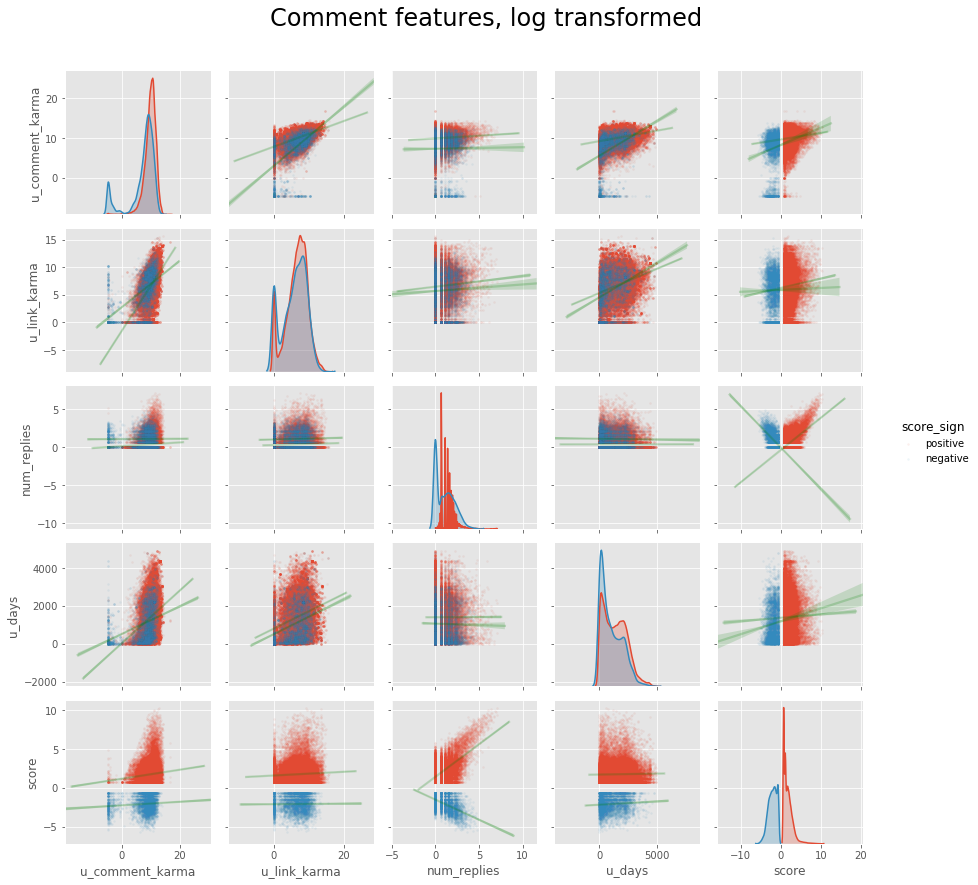

In [8]:
# set pairplot format
pairplot_kws = {'line_kws':{'color':'green','alpha': 0.2}, 'scatter_kws': {"s": 3, 'alpha': 0.05}}

# create a new df for all the log transformed features
df_log = df.copy()

# comment karma can be negative, so compute logs differently
df_log.u_comment_karma[df_log.u_comment_karma>0] = np.log(df_log.u_comment_karma[df_log.u_comment_karma>0])
df_log.u_comment_karma[df_log.u_comment_karma<0] = -np.log(df_log.u_comment_karma[df_log.u_comment_karma<0].abs())

df_log.u_link_karma[df_log.u_link_karma>0] = np.log(df_log.u_link_karma[df_log.u_link_karma>0])

df_log.num_replies[df_log.num_replies>0] = np.log(df_log.num_replies[df_log.num_replies>0])

# comment score can be negative, so compute logs differently
df_log.score[df_log.score>0] = np.log(df_log.score[df_log.score>0])
df_log.score[df_log.score<0] = -np.log(df_log.score[df_log.score<0].abs())

# get rid of comments with 0 scores 
df_log = df_log[df_log.score!=0]

# plt.figure(figsize=(10, 10));
pp = sns.pairplot(df_log, vars=cols2compare, hue='score_sign', kind='reg', plot_kws=pairplot_kws);

pp.fig.tight_layout(rect=[0, 0, .90, 0.92]);
pp.fig.suptitle('Comment features, log transformed\n\n', fontsize=24);


### Correlation matrix

I'll take a look at how these features correlate with each other. Since num_replies is being nonlinear at 0, I'll split the samples again between pos and neg vote scores.

Looking at correlations between vote score and other features:
- u_comment_karma: r=0.25 = keep
- u_link_karma: r=0.05 = drop.
- num_replies: r=-0.48(neg score), 0.63(pos score) = keep but need to fix 
- u_days: r=0.09 = drop.


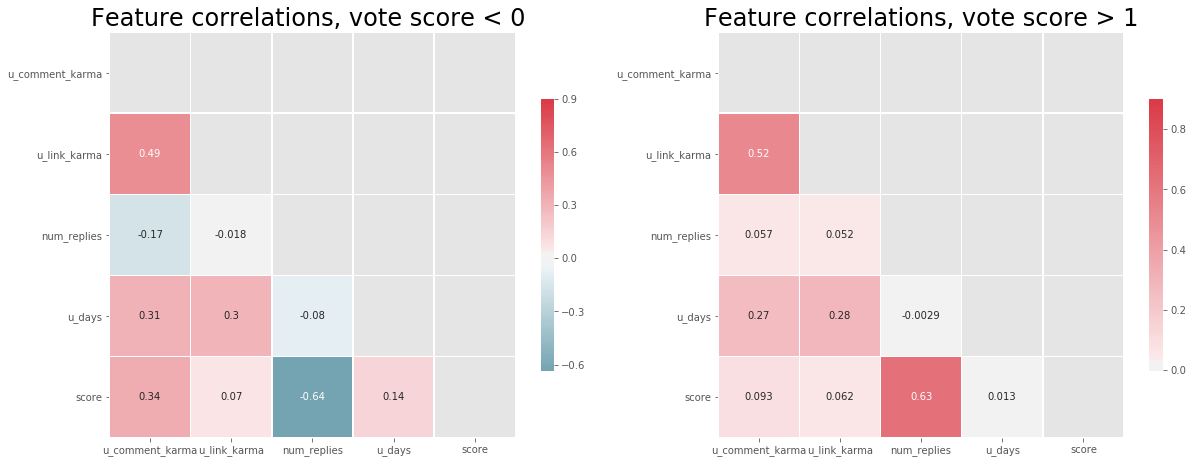

In [9]:
# Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
mask = np.zeros([len(cols2compare),len(cols2compare)], dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_log[df_log.score<1][cols2compare].corr(), mask=mask, cmap=cmap, vmax=.9, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature correlations, vote score < 0 ', fontsize=24);

plt.subplot(1,2,2)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_log[df_log.score>=1][cols2compare].corr(), mask=mask, cmap=cmap, vmax=.9, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature correlations, vote score > 1', fontsize=24);


### Fixing num_replies

It occurs to me that the behavior of num_replies vs vote score (an indication of approval/disapproval) makes sense psychologically: people tend to reply to comments that they either really like, or really hate. In fact this is the phenomenon that internet trolls exploit to get the reaction they seek from other users: post something nasty and outrage others into replying. So, really, I can view comment replies as likely either positive or negative, and I can make that assessment using the vote score: if a comment has a negative vote score, then replies can be assumed to be negative.

Result: setting num_replies for comments with scores < 0 to be negative makes the vote score vs num replies regression linear.


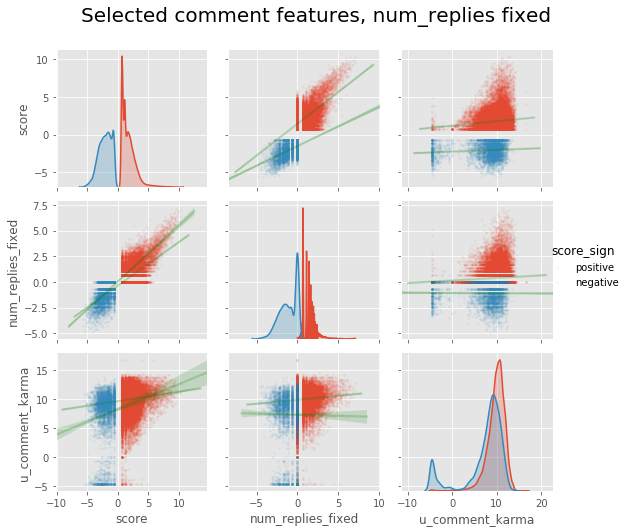

In [10]:
cols2compare = ['score', 'num_replies_fixed', 'u_comment_karma' ]

# make numreplies negative if vote score is negative
df_log['num_replies_fixed'] = df_log.num_replies
df_log.num_replies_fixed[df_log.score<0] = -df_log.num_replies_fixed[df_log.score<0]

pp = sns.pairplot(df_log, vars=cols2compare, hue='score_sign', kind='reg', plot_kws=pairplot_kws);

pp.fig.tight_layout(rect=[0, 0, .90, 0.92]);
pp.fig.suptitle('Selected comment features, num_replies fixed', fontsize=20);


### Correlation matrix for selected features and fixed num_replies

All of the features have positive correlations now across the range of values. 

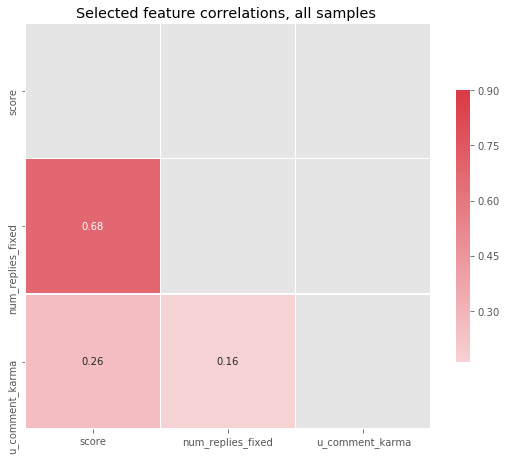

In [11]:
# Generate a mask for the upper triangle
mask = np.zeros([len(cols2compare),len(cols2compare)], dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_log[cols2compare].corr(), mask=mask, cmap=cmap, vmax=.9, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Selected feature correlations, all samples ');


## PCA analysis

Since I'm only using three features, the max PCA dimensions will be 2.

In [12]:
from sklearn.decomposition import PCA

cols2compare = ['score', 'num_replies_fixed', 'u_comment_karma' ]

pcascores = PCA(n_components=2).fit_transform(df_log[cols2compare])
df_log['pca_score1'] = pcascores[:,0]
df_log['pca_score2'] = pcascores[:,1]


### Compare PCA 1 & 2 with vote score

Looks like PCA 2 is more closely correlated with vote score, but not PCA 1. I'll use PCA 2 then, since I want the new score to be aligned with vote score.

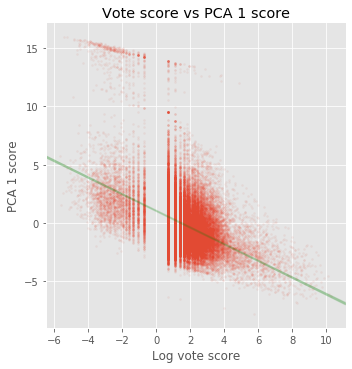

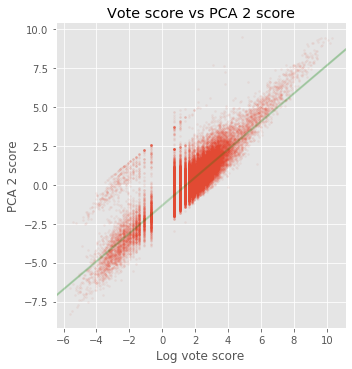

In [13]:
sp = sns.lmplot(data=df_log, x='score', y='pca_score1',
                line_kws={'color':'green','alpha': 0.2}, scatter_kws={"s": 3, 'alpha': 0.05});
plt.tight_layout();
plt.xlabel('Log vote score')
plt.ylabel('PCA 1 score')
plt.title('Vote score vs PCA 1 score');

sp = sns.lmplot(data=df_log, x='score', y='pca_score2',
                line_kws={'color':'green','alpha': 0.2}, scatter_kws={"s": 3, 'alpha': 0.05});
plt.tight_layout();
plt.xlabel('Log vote score')
plt.ylabel('PCA 2 score')
plt.title('Vote score vs PCA 2 score');


### Pairplot of selected variables vs PCA 1 and PCA 2 

PCA 2 appears to be mostly influenced by vote score (good!), but also is nicely correlated with number of replies. Comment karma seems to be the strongest influence on PCA 1, so it doesn't contribute to the PCA 2 score.

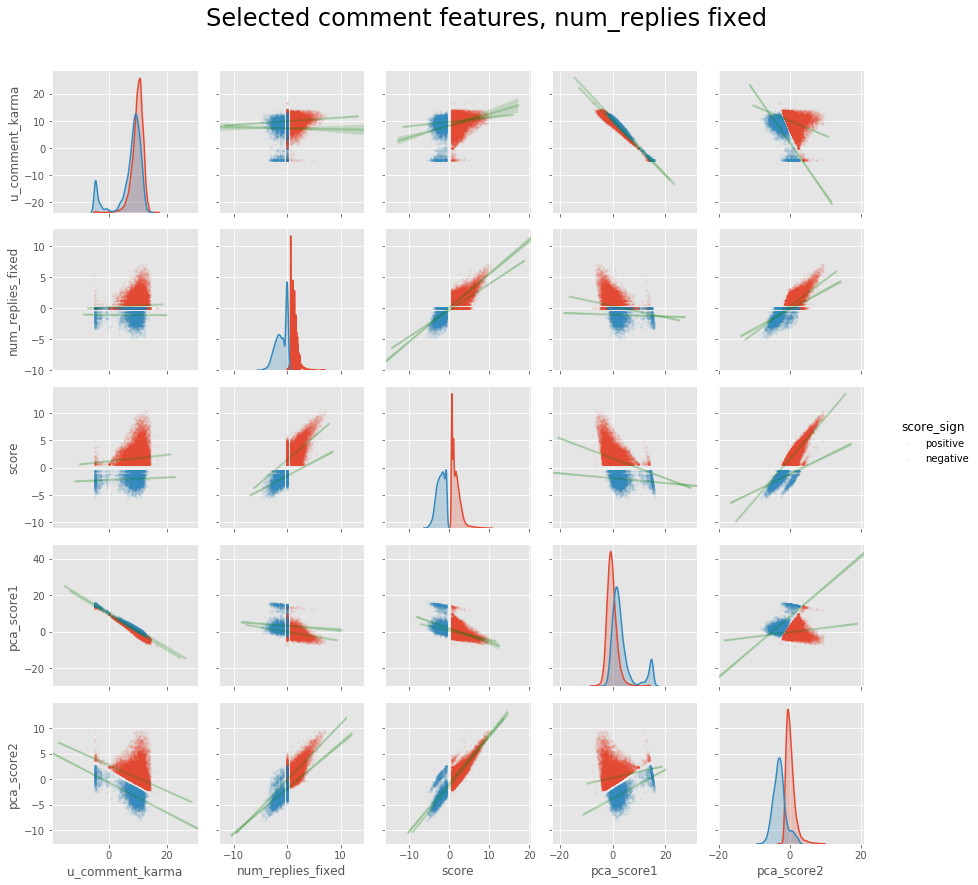

In [14]:

cols2compare = ['u_comment_karma', 'num_replies_fixed', 'score', 
                'pca_score1', 'pca_score2']

pp = sns.pairplot(df_log, vars=cols2compare, hue='score_sign', 
                  kind='reg', plot_kws=pairplot_kws);

pp.fig.tight_layout(rect=[0, 0, .90, 0.92]);
pp.fig.suptitle('Selected comment features, num_replies fixed', 
                fontsize=24);


### Correlate selected features against PCA 1 and PCA 2

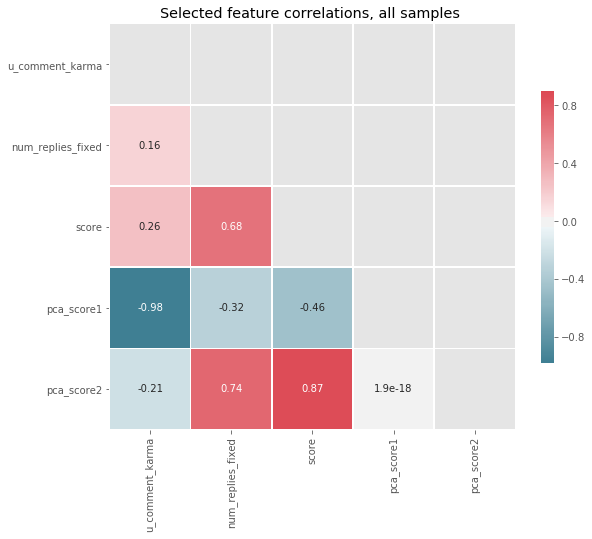

In [15]:
# Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
mask = np.zeros([len(cols2compare),len(cols2compare)], dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_log[cols2compare].corr(), mask=mask, cmap=cmap, vmax=.9, 
            center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Selected feature correlations, all samples ');


## Create a new datafile with PCA score

- Create a new dataframe with text and PCA 2 score as our label
- standardize the score and range it between +/-5
  - Split pos and neg scores and standardize each separately.
  - Generate before vs after histograms

- Save the dataframe to CSV

PCA score negative std=1.04, positive = 1.229


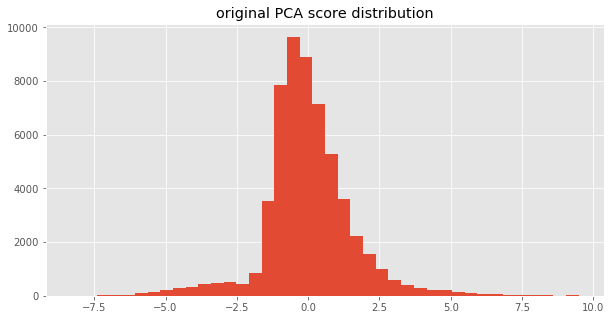

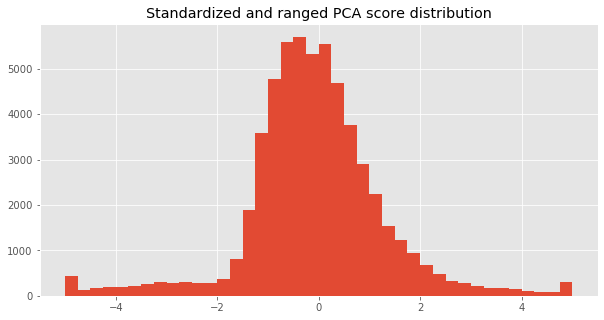

In [16]:
from sklearn.preprocessing import StandardScaler

# create output dataframe
df_labeled = df.copy() # copy original unmodified dataframe
# using PCA 2 as score
df_labeled['pca_score'] = df_log.pca_score2

# plot the original PCA score distribution
plt.figure(figsize=(10, 5))
df_labeled.pca_score.hist(bins=40)
plt.title('original PCA score distribution')

# range and adjust scores using stds for pos and neg values
stdneg = df_labeled.pca_score[df_labeled.pca_score<0].std()
stdpos = df_labeled.pca_score[df_labeled.pca_score>0].std()
print('PCA score negative std=%1.2f, positive = %1.3f'%(stdneg,stdpos))

# standardize the range, treat pos and neg scores separately
df_labeled.pca_score[df_labeled.pca_score<0] = df_labeled.pca_score[df_labeled.pca_score<0]/stdneg
df_labeled.pca_score[df_labeled.pca_score>0] = df_labeled.pca_score[df_labeled.pca_score>0]/stdpos

# threshold scores so that we have a range of +/-5
df_labeled.pca_score[df_labeled.pca_score<-5] = -5
df_labeled.pca_score[df_labeled.pca_score>5] = 5

plt.figure(figsize=(10, 5))
df_labeled.pca_score.hist(bins=40)
plt.title('Standardized and ranged PCA score distribution')

df_labeled.to_csv(csvfilename+'_labeled.csv')